In [1]:
### Transmission through Ge
import os 
import sys
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from math import *
import stpy
#### Import SACLA python library
#os.system("module load python/SACLA_python-3.7")
# os.system("python3")
import dbpy
import stpy
import pandas as pd
from scipy.optimize import curve_fit

from mpccd import *

class beam_analysis():
    def __init__(self, beamline, run, detID):
        self.run = run
        self.bl = beamline
        self.run_info = dbpy.read_runinfo(beamline, run)
        self.detID = detID
        self.taglist = dbpy.read_taglist_byrun(beamline, run)
        self.high_tag = dbpy.read_hightagnumber(beamline, run)
        self.start_tag = self.run_info['start_tagnumber']
        self.end_tag = self.run_info['end_tagnumber']
    
    def get_equip_data_pertag(self, tagnumber):
        '''
        Get equipment data per tag 
        equipment --- can be anything, you can find the equipment ID 
        '''
        data = dbpy.read_syncdatalist_float(self.detID, self.high_tag, self.taglist)
        index = int((tagnumber - self.start_tag)/2)
        return data[index]


In [2]:
class rocking_curve_analysis():
    def __init__(self, beamline, run):
        self.run = run
        self.bl = beamline
        self.run_info = dbpy.read_runinfo(beamline, run)
        self.taglist = dbpy.read_taglist_byrun(beamline, run)
        self.high_tag = dbpy.read_hightagnumber(beamline, run)
        self.start_tag = self.run_info['start_tagnumber']
        self.end_tag = self.run_info['end_tagnumber']
        self.shutter_mask = self.shutter()
    def get_equip_data(self, equip_ID):
        data = dbpy.read_syncdatalist_float(equip_ID, self.high_tag, self.taglist)
        return data
    def get_equip_data_pertag(self, equip_ID, res, tagnumber):
        '''
        Get equipment data per tag 
        equipment --- can be anything, you can find the equipment ID 
        '''
        motor_pos = dbpy.read_syncdatalist_float(equip_ID, self.high_tag, self.taglist)
        index = int((tagnumber - self.start_tag)/2)
        print('index', index)
        pos = motor_pos[index]
        return {'equip_ID':equip_ID, 'motor_pulse': pos, 'motor_rotation': pos*res, 'resolution': res ,'tag': tagnumber}

    def get_equip_data_perrun(self, equip_ID, res):
        motor_pos = np.array(dbpy.read_syncdatalist_float(equip_ID, self.high_tag, self.taglist))
        
        return {'equip_ID':equip_ID, 'motor_pulse': motor_pos, 'motor_rotation': motor_pos*res, 'resolution': res, 'tag_list': self.taglist, 'run': self.run}
    def read_det(self, detID):
        
        taglist = np.array(self.taglist)[self.shutter_mask]
        numIm = len(self.taglist)
        print('Run: {}\nNumber of images: {}\nDetector ID: {}'.format(self.run, numIm, detID))
    
        #stpy.StorageReader(detectorID, bl, run_numbers)
        #run_numbers: tuple of run list
        obj = stpy.StorageReader(detID, 3, (self.run,))
        buff = stpy.StorageBuffer(obj)
        obj.collect(buff, self.taglist[0])
        im2D = buff.read_det_data(0)

        im2Dall = np.zeros((numIm, len(im2D[:,0]), len(im2D[0,:])))
        im2Dall[0] = im2D.copy()

        i = 1
        for tag in self.taglist[1:]:
            if i % 100 == 0:
                sys.stdout.write('\r%d' % i)
                sys.stdout.flush()
            obj.collect(buff, tag)
            im2Dall[i] = buff.read_det_data(0).copy()
            i += 1
    
        return im2Dall
    def read_det_sbt(self,  detID, imDark):
        #Apply shutter mask to filter out the ones with shutter closed
        
        taglist = np.array(self.taglist)[self.shutter_mask]
        numIm = len(taglist)
        print('\nRun: {}\nNumber of images: {}\nDetector ID: {}'.format(self.run, numIm, detID))
    
        #stpy.StorageReader(detectorID, bl, run_numbers)
        #run_numbers: tuple of run list
        obj = stpy.StorageReader(detID, 3, (self.run,))
        buff = stpy.StorageBuffer(obj)
        obj.collect(buff, taglist[0])
        im2D = buff.read_det_data(0)

        im2Dall_sbt = np.zeros((numIm, len(im2D[:,0]), len(im2D[0,:])))
        im2Dall_sbt[0] = im2D - imDark

        i = 1
        for tag in taglist[1:]:
            if i % 100 == 0:
                sys.stdout.write('\r%d' % i)
                sys.stdout.flush()
            obj.collect(buff, tag)
            im2Dall_sbt[i] = buff.read_det_data(0) - imDark
            i += 1

        return im2Dall_sbt
        
    def shutter(self):
        shutter = np.array(dbpy.read_syncdatalist_float('xfel_bl_3_shutter_1_open_valid/status', self.high_tag, self.taglist))
        shutter_mask = shutter==1.0
        shutter_mask = np.array(shutter, dtype=bool)

        return shutter_mask

    def calib_factor(self, trans, MPCCD_calib, roi_size):
        # bm_calib = self.get_equip_data_perrun('xfel_bl_3_st_4_bm_1_pd/charge_calib_in_joule', 1)['motor_pulse'][self.shutter_mask]
        beamIN = self.get_equip_data_perrun('xfel_bl_3_st_4_bm_1_pd/charge_calib_in_joule', 1)['motor_pulse'][self.shutter_mask] * trans  / roi_size
        return 10**4 * 1.6e-19 / MPCCD_calib / beamIN
    
    def rocking_curve(self, equip_ID, res, imavg, roi_size, trans, MPCCD_calib):
        # imavg should already be shutter-masked
        # res is the resolution of this particular motor (equip_ID)
        motor_pos = self.get_equip_data_perrun(equip_ID, res)['motor_rotation'][self.shutter_mask]
        intensity = imavg
        transmission = intensity * self.calib_factor(trans, MPCCD_calib, roi_size)
        plt.figure()
        plt.plot(motor_pos, transmission, '.')
        plt.grid()
        plt.xlabel(f'{equip_ID} / degree')
        plt.ylabel('average transmission (ROI)')
        plt.show()
        return motor_pos, transmission

    def rocking_curve_summed(self, equip_ID, res, imavg, roi_size, trans, MPCCD_calib):
        # imavg should already be shutter-masked
        # res is the resolution of this particular motor (equip_ID)
        motor_pos = self.get_equip_data_perrun(equip_ID, res)['motor_rotation'][self.shutter_mask]
        intensity = imavg
        transmission = intensity * self.calib_factor(trans, MPCCD_calib, 1)
        plt.figure()
        plt.plot(motor_pos, transmission, '.')
        plt.grid()
        plt.xlabel(f'{equip_ID} / degree')
        plt.ylabel('average transmission (ROI)')
        plt.show()
        return motor_pos, transmission

#########################################################
    #############################################
    
    def rocking_curve_avgd(self, equip_ID, res, imavg):
        # imavg should already be shutter-masked
        # res is the resolution of this particular motor (equip_ID)
        motor_pos = self.get_equip_data_perrun(equip_ID, res)['motor_rotation'][self.shutter_mask]

        df = pd.DataFrame({'motor_pos': motor_pos, 'imavg': imavg})
        df_avg = df.groupby('motor_pos', as_index=False)['imavg'].mean()

        motor_pos_unique = df_avg['motor_pos'].to_numpy()
        imavg_mean = df_avg['imavg'].to_numpy()        
        intensity = imavg_mean

        return motor_pos_unique, intensity
        #plt.figure()
        #plt.plot(motor_pos_unique, intensity, '.')
        #plt.grid()
        #plt.xlabel(f'{equip_ID} / degree')
        #plt.ylabel('average intensity (ROI)')
        #plt.show()
        
#########################################################
    #############################################
    
    def rocking_curve_fit(self, equip_ID, res, imavg):
        # imavg should already be shutter-masked
        # res is the resolution of this particular motor (equip_ID)
        motor_pos = self.get_equip_data_perrun(equip_ID, res)['motor_rotation'][self.shutter_mask]

        df = pd.DataFrame({'motor_pos': motor_pos, 'imavg': imavg})
        df_avg = df.groupby('motor_pos', as_index=False)['imavg'].mean()

        motor_pos_unique = df_avg['motor_pos'].to_numpy()
        imavg_mean = df_avg['imavg'].to_numpy()        
        intensity = imavg_mean

        def gaussian(x, A, mu, sigma, offset):
            return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + offset

        A0 = np.max(imavg_mean) - np.min(imavg_mean)
        mu0 = motor_pos_unique[np.argmax(imavg_mean)]
        sigma0 = (motor_pos_unique.max() - motor_pos_unique.min()) / 10
        offset0 = np.min(imavg_mean)

        p0 = [A0, mu0, sigma0, offset0]

        popt, pcov = curve_fit(gaussian, motor_pos_unique, imavg_mean, p0=p0)

        A, mu, sigma, offset = popt
        print(f"A = {A:.3e}, mu = {mu:.4f}, sigma = {sigma:.4f}, offset = {offset:.3e}")

        x_fit = np.linspace(motor_pos_unique.min(), motor_pos_unique.max(), 500)
        y_fit = gaussian(x_fit, *popt)
        
        plt.figure()
        plt.plot(x_fit, y_fit, '.')
        plt.grid()
        plt.xlabel(f'{equip_ID} / degree')
        plt.ylabel('average intensity (ROI)')
        plt.show()


def read_det(bl, run, detID):
    taglist = dbpy.read_taglist_byrun(3, run)
    numIm = len(taglist)
    print('Run: {}\nNumber of images: {}\nDetector ID: {}'.format(run, numIm, detID))
    
    #stpy.StorageReader(detectorID, bl, run_numbers)
    #run_numbers: tuple of run list
    obj = stpy.StorageReader(detID, 3, (run,))
    buff = stpy.StorageBuffer(obj)
    obj.collect(buff, taglist[0])
    im2D = buff.read_det_data(0)

    im2Dall = np.zeros((numIm, len(im2D[:,0]), len(im2D[0,:])))
    im2Dall[0] = im2D.copy()

    i = 1
    for tag in taglist[1:]:
        if i % 100 == 0:
            sys.stdout.write('\r%d' % i)
            sys.stdout.flush()
        obj.collect(buff, tag)
        im2Dall[i] = buff.read_det_data(0).copy()
        i += 1
    
    return im2Dall

def plot_roi(im, center_x, center_y, roi_size):
    # Calculate top-left corner of the ROI
    half = roi_size // 2
    top_left_x = center_x - half
    top_left_y = center_y - half

    plt.figure()
    plt.imshow(im)
    plt.colorbar()
    # Draw a red rectangle around ROI
    rect = plt.Rectangle((top_left_x, top_left_y), roi_size, roi_size,
                     linewidth=1, edgecolor='red', facecolor='none')

    plt.gca().add_patch(rect)

    # Draw horizontal and vertical center lines
    plt.axhline(y=center_y, color='red', linestyle='--', linewidth=0.5)
    plt.axvline(x=center_x, color='red', linestyle='--', linewidth=0.5)

    im_roi = im[center_y - half:center_y + half, center_x - half:center_x + half]
    print('summed intensity in ROI', np.sum(im_roi))
    plt.figure()
    plt.imshow(im_roi)
    plt.colorbar()

def get_ROI(im_all, center_x, center_y, roi_size):
    half = roi_size // 2
    top_left_x = center_x - half
    top_left_y = center_y - half
   
    im_roi = im_all[:, center_y - half:center_y + half, center_x - half:center_x + half]
    im_roi_avg = np.mean(im_roi, axis=(1, 2))
    return im_roi, im_roi_avg

def get_ROI_2(im_all, center_x, center_y, roi_size):
    half = roi_size // 2
    top_left_x = center_x - half
    top_left_y = center_y - half
   
    im_roi = im_all[:, center_y - half:center_y + half, center_x - half:center_x + half]
    im_roi_avg = []
    act_size = []
    for i in im_roi:
        try:
            avg_i = np.average(i, weights=i>100)
        except:
            im_roi_avg.append(0)
            act_size.append(25**2)   
        else:
            im_roi_avg.append(avg_i)
            act_size.append((i>100).sum())

    im_roi_avg = np.mean(im_roi, axis=(1, 2))
                            
    return im_roi, np.array(im_roi_avg), np.array(act_size)


In [108]:
# ### Crystal 1 Ge (220) rocking curve - look at diffracted signal
# run = 1616856

# rock = rocking_curve_analysis(3, run)
# run_info = dbpy.read_runinfo(3, run)
# print(run_info)
# # detID = 'MPCCD-1B1-M03-006'  #3
# detID = 'MPCCD-1N0-M06-004'  #2
# # detID = 'MPCCD-1N0-M07-005'  #1

# runDark = 1616808


# imDark = np.mean(read_det(3, runDark, detID),0)
# im2Dall = rock.read_det_sbt(detID, imDark)
# im2Dave = np.mean(im2Dall, 0)

In [107]:
# roiX  = 210
# roiY  = 510
# roiSize = 40

# plot_roi(im2Dave, roiX, roiY, roiSize)
# im_roi, imavg, act_size = get_ROI_2(im2Dall, roiX, roiY, roiSize)   #(center_x, center_y, roi_size)
# # trans = 5.64981e-4

# #trans = 2.37693e-2

# Si_att_length = 133.706 ## micron
# Si_att_thickness = 1000 ## micron

# trans = np.exp(- Si_att_thickness/Si_att_length )

# x_diff, y_diff = rock.rocking_curve('xfel_bl_3_st_4_motor_36/position', 1e-4, imavg, act_size, trans, 103)
# x_diff, y_diff, fit_diff = rock.rocking_curve_fit('xfel_bl_3_st_4_motor_36/position',imavg, act_size, 1, trans, 103)
# # transmission = fit_440[0]
# # print(transmission)

In [121]:
run = 1617650
darkRun = 1616808
beamline = 3
detectorID_MPCCD3 = 'MPCCD-1B1-M03-006'
detectorID_MPCCD2 = 'MPCCD-1N0-M06-004'
detectorID_MPCCD1 = 'MPCCD-1N0-M07-005'


base_path = "."

MPCCD_3 = MPCCDProcessing(base_path, detectorID_MPCCD3)
MPCCD_2 = MPCCDProcessing(base_path, detectorID_MPCCD2)
MPCCD_1 = MPCCDProcessing(base_path, detectorID_MPCCD1)



In [122]:
imDall, imDave  = MPCCD_1.load_images(run,darkRun)

Creating dark run image
Run: 1616808
Number of images: 1000
Detector ID: MPCCD-1N0-M07-005
900
Run: 1617650
Number of images: 5000
Detector ID: MPCCD-1N0-M07-005
Dark runs subtracted
4900

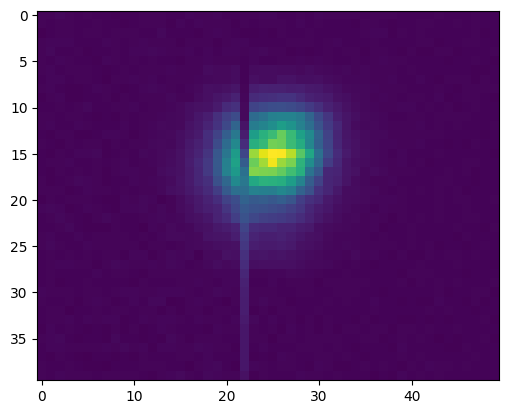

In [123]:
plt.imshow(imDave[600:640,230:280])
roi = [600,620,230,290]

Run: 1616808
Number of images: 1000
Detector ID: MPCCD-1N0-M07-005
9001.0


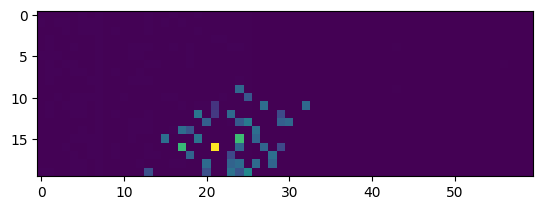

1.0


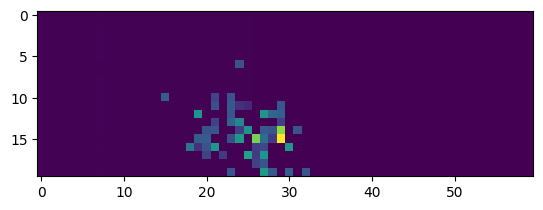

1.0


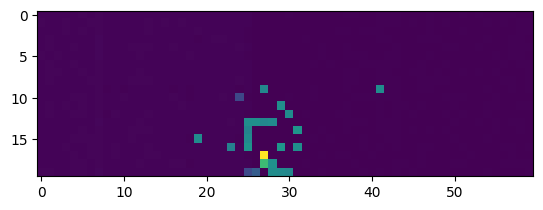

1.0


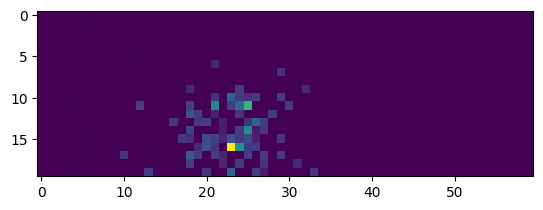

1.0


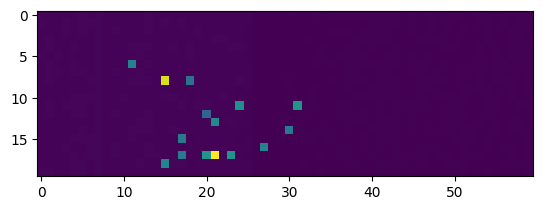

In [124]:
beamline = 3
taglist = dbpy.read_taglist_byrun(beamline, run)
highTag = dbpy.read_hightagnumber(beamline, run)

imDall, imDave  = MPCCD_1.load_images(darkRun,None,False)

darkRunImage = imDave

# ['xfel_bl_3_st_4_bm_1_pd_upper_peak/voltage',
#  'xfel_bl_3_st_4_bm_1_pd_lower_peak/voltage',
#  'xfel_bl_3_st_4_bm_1_pd_right_peak/voltage',
#  'xfel_bl_3_st_4_bm_1_pd_left_peak/voltage',

# upDiodes    = []
# lowDiodes   = []
# leftDiodes  = []
# rightDiodes = []

intensityOnMPCCD1 = []

shutter = dbpy.read_syncdatalist_float('xfel_bl_3_shutter_1_open_valid/status', highTag, taglist)
obj = stpy.StorageReader('MPCCD-1N0-M07-005', 3, (run,))
buff = stpy.StorageBuffer(obj)
obj.collect(buff, taglist[0])
im2D = buff.read_det_data(0)

sumOfIntensity = []
lowThresh = 10
lowFlux = []
plotNext = False
for i in range(np.shape(taglist)[0]):
    
    tag = taglist[i]
    obj.collect(buff, tag)
    image = buff.read_det_data(0)
    image[np.where(image < 40)] = 0.0
    darkSubtractedImage =  (image - darkRunImage) / 102.0
    fluxInROI = np.nansum(darkSubtractedImage[roi[0]:roi[1],roi[2]:roi[3]])
    if ((fluxInROI < lowThresh) or (shutter[i] == 0)):
        fluxInROI = np.nan
    sumOfIntensity.append(fluxInROI)
    if (i % 1000 == True or plotNext == True):
        if (shutter[i] == 0):
            plotNext=True
            continue
        print(shutter[i])
        plt.imshow(darkSubtractedImage[roi[0]:roi[1],roi[2]:roi[3]])
        plt.show()
        plotNext=False
    
        

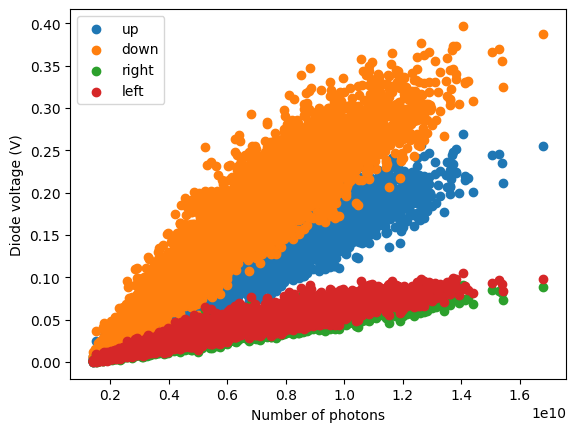

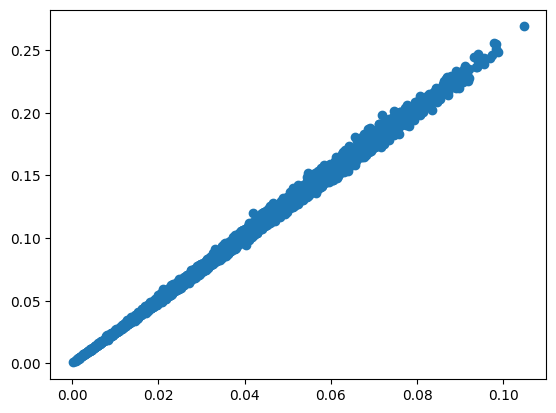

In [125]:
Si_att_length = 133.706
Si_length     = 2500.0

attenuationThroughFilter = np.exp(-Si_length/Si_att_length)

upperDiode = dbpy.read_syncdatalist_float('xfel_bl_3_st_4_bm_1_pd_upper_fitting_peak/voltage', highTag,taglist)
lowerDiode = dbpy.read_syncdatalist_float('xfel_bl_3_st_4_bm_1_pd_lower_fitting_peak/voltage', highTag,taglist)
rightDiode = dbpy.read_syncdatalist_float('xfel_bl_3_st_4_bm_1_pd_right_fitting_peak/voltage', highTag,taglist)
leftDiode  = dbpy.read_syncdatalist_float('xfel_bl_3_st_4_bm_1_pd_left_fitting_peak/voltage', highTag,taglist)
plt.scatter(sumOfIntensity / attenuationThroughFilter,upperDiode,label="up")
plt.scatter(sumOfIntensity / attenuationThroughFilter,lowerDiode,label="down")
plt.scatter(sumOfIntensity / attenuationThroughFilter,rightDiode,label="right")
plt.scatter(sumOfIntensity / attenuationThroughFilter,leftDiode,label="left")
plt.xlabel("Number of photons")


plt.ylabel("Diode voltage (V)")
plt.legend()
plt.show()



plt.scatter(leftDiode,upperDiode)

In [126]:
run = 1617651
darkRun = 1616808
beamline = 3
detectorID_MPCCD3 = 'MPCCD-1B1-M03-006'
detectorID_MPCCD2 = 'MPCCD-1N0-M06-004'
detectorID_MPCCD1 = 'MPCCD-1N0-M07-005'


base_path = "."

MPCCD_3 = MPCCDProcessing(base_path, detectorID_MPCCD3)
MPCCD_2 = MPCCDProcessing(base_path, detectorID_MPCCD2)
MPCCD_1 = MPCCDProcessing(base_path, detectorID_MPCCD1)

beamline = 3
taglist = dbpy.read_taglist_byrun(beamline, run)
highTag = dbpy.read_hightagnumber(beamline, run)

imDall, imDave  = MPCCD_1.load_images(darkRun,None,False)

darkRunImage = imDave

# ['xfel_bl_3_st_4_bm_1_pd_upper_peak/voltage',
#  'xfel_bl_3_st_4_bm_1_pd_lower_peak/voltage',
#  'xfel_bl_3_st_4_bm_1_pd_right_peak/voltage',
#  'xfel_bl_3_st_4_bm_1_pd_left_peak/voltage',

# upDiodes    = []
# lowDiodes   = []
# leftDiodes  = []
# rightDiodes = []

intensityOnMPCCD1 = []

shutter = dbpy.read_syncdatalist_float('xfel_bl_3_shutter_1_open_valid/status', highTag, taglist)
obj = stpy.StorageReader('MPCCD-1N0-M07-005', 3, (run,))
buff = stpy.StorageBuffer(obj)
obj.collect(buff, taglist[0])
im2D = buff.read_det_data(0)

sumOfIntensity = []
lowThresh = 0
lowFlux = []
plotNext = False
for i in range(np.shape(taglist)[0]):
    
    tag = taglist[i]
    obj.collect(buff, tag)
    image = buff.read_det_data(0)
    image[np.where(image < 40)] = 0.0
    darkSubtractedImage =  (image - darkRunImage) / 102.0
    fluxInROI = np.nansum(darkSubtractedImage[roi[0]:roi[1],roi[2]:roi[3]])
    if ((fluxInROI < lowThresh) or (shutter[i] == 0)):
        fluxInROI = np.nan
    sumOfIntensity.append(fluxInROI)
    # if (i % 100 == True or plotNext == True):
    #     if (shutter[i] == 0):
    #         plotNext=True
    #         continue
        # print(shutter[i])
        # plt.imshow(darkSubtractedImage[roi[0]:roi[1],roi[2]:roi[3]])
        # plt.show()
        # plt.hist(darkSubtractedImage[roi[0]:roi[1],roi[2]:roi[3]].flatten(),bins=1000)
        # plt.yscale("log")
        # plt.show()
        # plotNext=False
    
        

Run: 1616808
Number of images: 1000
Detector ID: MPCCD-1N0-M07-005
900

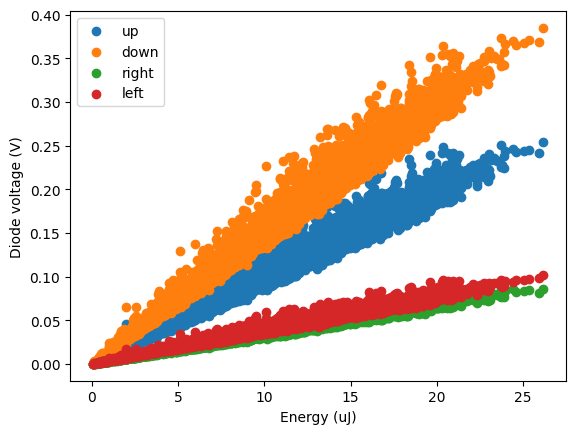

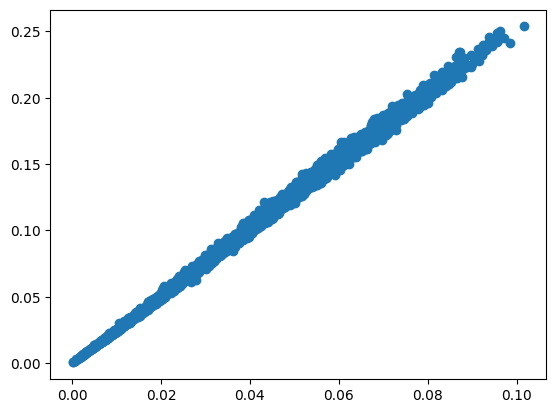

In [127]:
upperDiode = dbpy.read_syncdatalist_float('xfel_bl_3_st_4_bm_1_pd_upper_fitting_peak/voltage', highTag,taglist)
lowerDiode = dbpy.read_syncdatalist_float('xfel_bl_3_st_4_bm_1_pd_lower_fitting_peak/voltage', highTag,taglist)
rightDiode = dbpy.read_syncdatalist_float('xfel_bl_3_st_4_bm_1_pd_right_fitting_peak/voltage', highTag,taglist)
leftDiode  = dbpy.read_syncdatalist_float('xfel_bl_3_st_4_bm_1_pd_left_fitting_peak/voltage', highTag,taglist)

Si_att_length = 133.706
Si_length     = 2000.0

attenuationThroughFilter = np.exp(-Si_length/Si_att_length)

plt.scatter(1e4 * 1.6e-19 * 1e6 * np.array(sumOfIntensity / attenuationThroughFilter),upperDiode,label="up")
plt.scatter(1e4 * 1.6e-19 * 1e6 * np.array(sumOfIntensity / attenuationThroughFilter),lowerDiode,label="down")
plt.scatter(1e4 * 1.6e-19 * 1e6 * np.array(sumOfIntensity / attenuationThroughFilter),rightDiode,label="right")
plt.scatter(1e4 * 1.6e-19 * 1e6 * np.array(sumOfIntensity / attenuationThroughFilter),leftDiode,label="left")
plt.xlabel("Energy (uJ)")
plt.ylabel("Diode voltage (V)")
plt.legend()
plt.show()



plt.scatter(leftDiode,upperDiode)

Coefficients: [95.95704575  0.40262087]
y =  95.95704574515567  + 0.40262087141555075 *x


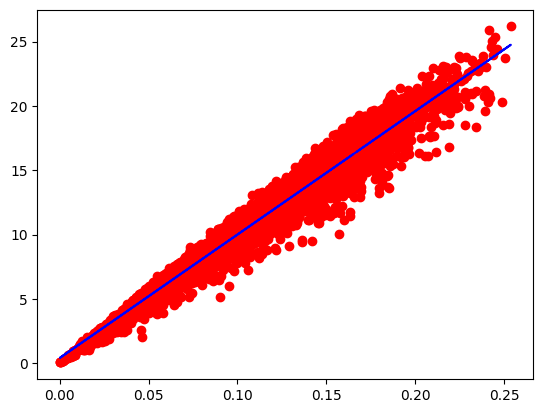

In [131]:
# Perform linear fit
energyOnMPCCDinMicroJoule = 1e4 * 1.6e-19 * 1e6 * np.array(sumOfIntensity / attenuationThroughFilter)

upperDiode = np.array(upperDiode)
indicies =  ~np.isnan(upperDiode)

energyOnMPCCDinMicroJouleFiltered = energyOnMPCCDinMicroJoule[ indicies]
upperDiodeFiltered                = upperDiode[ indicies ]

coefficients = np.polyfit(upperDiodeFiltered, energyOnMPCCDinMicroJouleFiltered , 1)
linear_model = np.poly1d(coefficients)

# Print the coefficients
print("Coefficients:", coefficients)

# Plot the data and the linear fit
plt.scatter(upperDiode,energyOnMPCCDinMicroJoule, color='red', label='Data points')
plt.plot(upperDiodeFiltered, linear_model(upperDiodeFiltered), color='blue', label='Linear fit')
print("y = ", coefficients[0], " +", coefficients[1], "*x")



Coefficients: [ 0.01295195 -0.00013973]
y =  0.012951951718768034  + 0.012951951718768034 *x


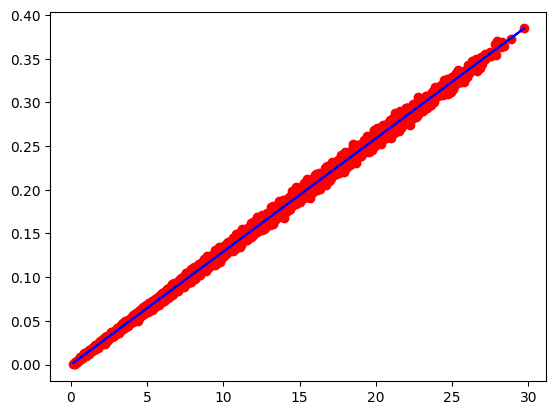

In [106]:
# Perform linear fit
energyOnMPCCDinMicroJoule = 1e4 * 1.6e-19 * 1e6 * np.array(sumOfIntensity / attenuationThroughFilter)

lowerDiode = np.array(lowerDiode)
indicies =  ~np.isnan(lowerDiode)

energyOnMPCCDinMicroJouleFiltered = energyOnMPCCDinMicroJoule[ indicies]
lowerDiodeFiltered                = lowerDiode[ indicies ]

coefficients = np.polyfit(energyOnMPCCDinMicroJouleFiltered, lowerDiodeFiltered, 1)
linear_model = np.poly1d(coefficients)

# Print the coefficients
print("Coefficients:", coefficients)

# Plot the data and the linear fit
plt.scatter(energyOnMPCCDinMicroJouleFiltered, lowerDiodeFiltered, color='red', label='Data points')
plt.plot(energyOnMPCCDinMicroJouleFiltered, linear_model(energyOnMPCCDinMicroJouleFiltered), color='blue', label='Linear fit')
print("y = ", coefficients[0], " +", coefficients[0], "*x")

